## Swam Htet Aung
### p2435567
### DAAA/FT/2B/22
### ST1504 DELE CA1 Part B

##  Recurrent Neural Network
### Sentiment Analysis of Movie Reviews

## Background research


Sentiment analysis is a common task in natural language processing (NLP) that aims to determine whether a piece of text expresses a positive or negative opinion. In this project, we analyze movie reviews using deep learning techniques.

The dataset provided includes reviews for the movie "Avengers: Endgame" in multiple languages, along with their corresponding sentiment scores, which indicate how much the reviewer liked or disliked the movie.





Our goal is to build a recurrent neural network, starting with a simple baseline and improving it through better preprocessing, feature engineering, and model architecture.



#### Import

In [ ]:
# Essential imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Hyperparameter tuning (Keras Tuner)
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Translation (if needed)
from deep_translator import GoogleTranslator

# NLTK data downloads (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Mounting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading our dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/deleca1/Movie reviews.csv'
df = pd.read_csv(file_path)

## EDA and Feature Engineering

#### Observation

Let’s take a preview of the given dataset.

In [ ]:
print(f"Number of rows in the dataset: {len(df)}")


Number of rows in the dataset: 527


There are a total of 527 reviews in our dataset.

In [ ]:
df.head()

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persembahan terbaik. Kurang puas hati.",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Sungguh menghiburkan!,0.2,NaN,Malay


As we can see, the dataset contains reviews in multiple foreign languages, and also null values. Let's exmaine it further.






Language
English    298
Malay      226
Chinese      2
Nippon       1
Name: count, dtype: int64


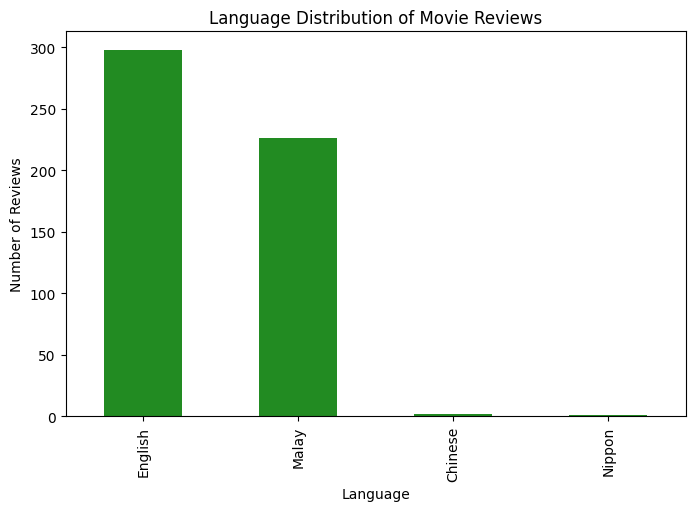

In [ ]:
# Count languages
language_counts = df['Language'].value_counts()

# Display counts
print(language_counts)

# Plot bar chart
language_counts.plot(kind='bar', figsize=(8,5), color='forestgreen')
plt.title('Language Distribution of Movie Reviews')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.show()


The majority of the reviews are in English or Malay, with only three reviews written in other foreign languages.

In [ ]:
# Checking null values
df.isnull().sum()

,0
Review,0
Score,2
"Are there ways for you to generate more data? Spliting up sentences, would that help?",527
Language,0


The third column contains only null values, confirming that it is irrelevant to our model. Therefore, I will remove this column to clean the data.

In [ ]:
# Deleting third column
df.drop(df.columns[2], axis=1, inplace=True)


In [ ]:
# Summary of statistics
df.describe()

,Score
count,525.000000
mean,0.282626
std,0.263022
min,0.001000
25%,0.100000
50%,0.120000
75%,0.500000
max,0.997413


There are 527 rows in total, but the count shows only 525, indicating that there are two null values in the column "Score". These will need to be addressed.

In [ ]:
# Rows that have null values
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)


       Review  Score Language
426    Ni hao    NaN  Chinese
493  Diabolic    NaN  English


There are two rows with null values. Although it is possible to estimate or impute the missing scores, incorrect guesses could introduce noise and negatively impact the model’s performance. Therefore, I will delete these two rows, leaving us with 525 rows.

In [ ]:
df_nonull = df.drop([426, 493]).reset_index(drop=True)
# df.reset_index(drop=True, inplace=True)


In [ ]:
print(f"Number of rows in the dataset: {len(df_nonull)}")

Number of rows in the dataset: 525


The earlier summary also indicates that most of the scores are around 0.1. Let's examine it further.

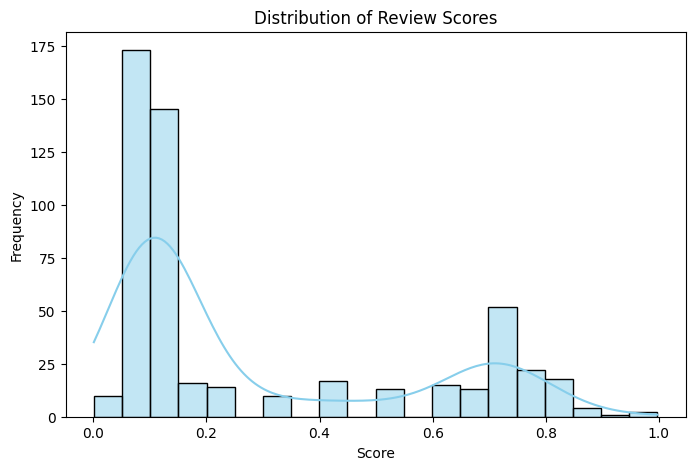

In [ ]:
# Histogram showing distribution of score
plt.figure(figsize=(8,5))
sns.histplot(df_nonull['Score'].dropna(), bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()



As expected, the majority of scores cluster around 0.1. This imbalance could affect model training later, so it’s important to keep this in mind.

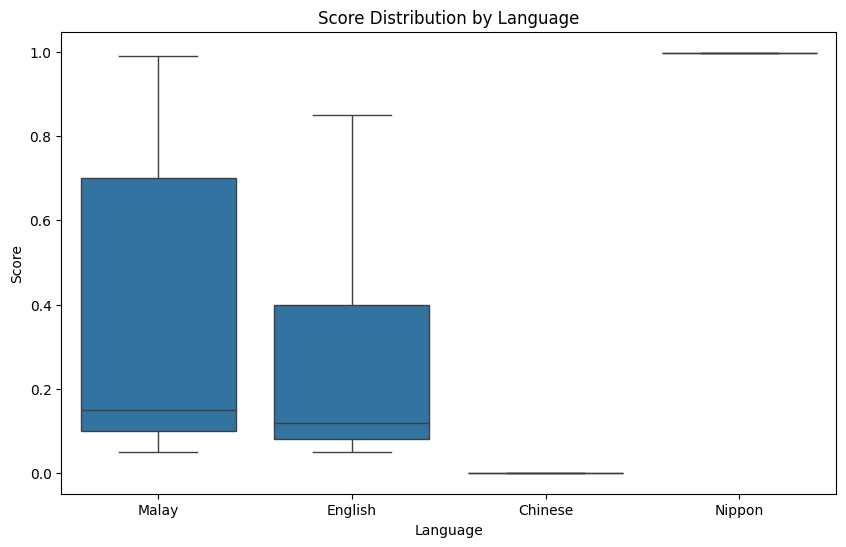

In [ ]:
# Box plot comparing score across different languages

plt.figure(figsize=(10,6))
sns.boxplot(x='Language', y='Score', data=df_nonull)
plt.title('Score Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Score')
plt.show()


The range of scores for reviews in Malay is the most spread out, indicating greater variability in sentiment. English reviews follow, showing a moderately wide spread. Notably, the median scores for both languages are below 0.5, suggesting that, on average, reviewers tend to express a score of below 0.5.

#### Translation of foreign languages

Now, I will translate the foreign language reviews into English using Deep Translator.

In [ ]:
# Make a copy of df_nonull
df_translated = df_nonull.copy()

# Identify rows where the language is not English
non_english_rows = df_translated[df_translated['Language'].str.lower() != 'english']

# Translate the non-English reviews
translated_texts = []

for review in tqdm(non_english_rows['Review'], desc="Translating reviews"):
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(str(review))
        translated_texts.append(translated)
    except Exception as e:
        print("Translation failed for review:", review)
        translated_texts.append(review)  # Fallback: keep original if translation fails

# Update the DataFrame with translated reviews
df_translated.loc[non_english_rows.index, 'Review'] = translated_texts
df_translated.loc[non_english_rows.index, 'Language'] = 'English'

# Print count of translated reviews
translated_count = (df_translated['Language'].str.lower() == 'english').sum() - \
                   (df_nonull['Language'].str.lower() == 'english').sum()
print("Reviews translated to English:", translated_count)


Translating reviews: 100%|██████████| 228/228 [00:13<00:00, 16.99it/s]

Reviews translated to English: 228


In [ ]:
print(df_translated['Language'].unique())


['English']


As we can see, now all our reviews are translated to English. Now I will add a new column called "Review_length", which is the number of words in each review, for further analysis.

#### Review length

In [ ]:
df_translated['Review_Length'] = df_translated['Review'].apply(lambda x: len(str(x).split()))


In [ ]:
df_translated.head(5)

,Review,Score,Language,Review_Length
0,This movie is great! Thrilling action and shocking plot.,0.1,English,9
1,This movie is great! Thrilling action and shocking plot.,0.9,English,9
2,This movie is great! Thrilling action and shocking plot.,0.5,English,9
3,"Unfortunately, the actor didn't give the best performance. Disappointed.",0.8,English,9
4,Complex and emotional storyline. So entertaining!,0.2,English,6


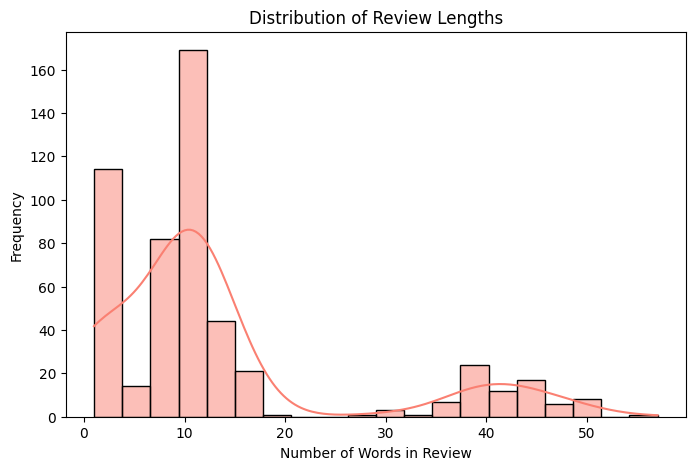

In [ ]:
# Histogram showing distribution of review length
plt.figure(figsize=(8, 5))
sns.histplot(df_translated['Review_Length'], bins=20, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words in Review')
plt.ylabel('Frequency')
plt.show()



Most reviews are relatively short, with only a few extending up to around 50 words.

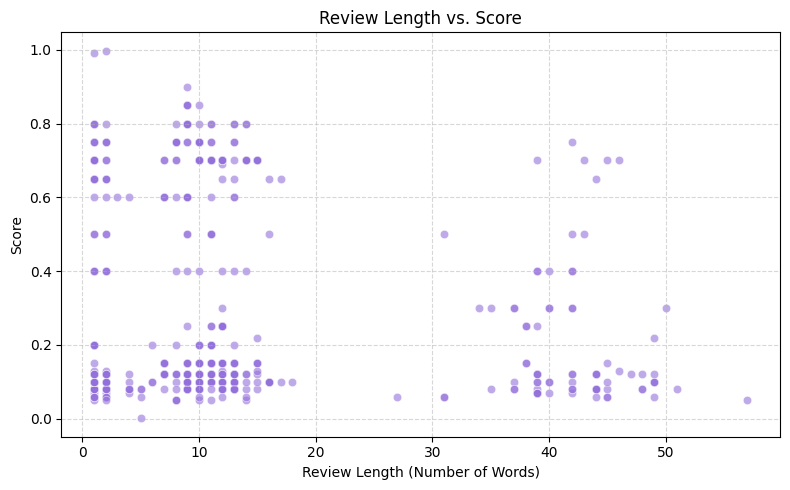

In [ ]:
# Scatter plot showing relationship between review length and score
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_translated, x='Review_Length', y='Score', color='mediumpurple', alpha=0.6)
plt.title('Review Length vs. Score')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


There doesn't appear to be a clear relationship between review length and score. However, we can observe that most reviews are relatively short, with scores primarily clustered around 0.1 to 0.2.

#### Sentiment (Classification)




I have decided to do classification architectures with the
given data because it’s simpler and more intuitive for users to understand overall sentiment. Instead of exact scores, people usually want to know if reviews are generally good or bad.

In [ ]:
df_sentiment = df_translated.copy()

In this dataset, lower scores indicate better (more positive) reviews, while higher scores represent worse (more negative) reviews. So, there are more positive reviews than bad reviews.

In [ ]:
# function to determine sentiment
def get_sentiment(score):
    if score > 0.5:
        return "Negative"
    elif score < 0.5:
        return "Positive"
    else:
        return "Neutral"


In [ ]:
df_sentiment['Sentiment'] = df_sentiment['Score'].apply(get_sentiment)

#### Duplicate reviews

Let's check for duplicate reviews.

In [ ]:
# Count duplicate reviews
duplicate_count = df_sentiment.duplicated(subset='Review').sum()
print("Number of duplicate reviews:", duplicate_count)


Number of duplicate reviews: 129


In [ ]:
# Step 1: Find duplicated reviews
duplicates = df_sentiment[df_sentiment.duplicated(subset='Review', keep=False)]

# Step 2: Find reviews with multiple unique Sentiment values
diff_sentiment_reviews = (
    duplicates.groupby('Review')['Sentiment']
    .nunique()
    .reset_index()
    .query('Sentiment > 1')['Review']
)

# Step 3: Filter rows where those reviews occur
diff_sentiment_duplicates = df_sentiment[df_sentiment['Review'].isin(diff_sentiment_reviews)]

# Step 4: Sort by 'Review' to group same ones, and index to preserve order
diff_sentiment_duplicates = diff_sentiment_duplicates.reset_index()
diff_sentiment_duplicates = diff_sentiment_duplicates.sort_values(by=['Review', 'index'])
diff_sentiment_duplicates = diff_sentiment_duplicates.set_index('index')

# Step 5: Display in full
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(diff_sentiment_duplicates)



,Review,Score,Language,Review_Length,Sentiment
index,,,,,
416,Complex,0.65,English,1,Negative
441,Complex,0.10,English,1,Positive
403,Epic,0.06,English,1,Positive
505,Epic,0.70,English,1,Negative
0,This movie is great! Thrilling action and shocking plot.,0.10,English,9,Positive
1,This movie is great! Thrilling action and shocking plot.,0.90,English,9,Negative
2,This movie is great! Thrilling action and shocking plot.,0.50,English,9,Neutral
422,Weak,0.75,English,1,Negative
447,Weak,0.50,English,1,Neutral


Now, I will manually verify the correct Sentiment for duplicate reviews. For example, between the first two duplicates, the first review’s Sentiment is the accurate one. After careful inspection, it’s clear that we should keep the first occurrence of each duplicate review when sentiments differ.

In [ ]:
df_nodup = df_sentiment.drop_duplicates(subset=['Review'], keep='first').copy()
df_nodup.reset_index(drop=True, inplace=True)

In [ ]:
duplicate_count = df_nodup.duplicated(subset='Review').sum()
print("Number of duplicate reviews:", duplicate_count)

Number of duplicate reviews: 0


#### Handling "Neutral" reviews

Neutral reviews often contain ambiguous or mixed sentiments, making it harder for the model to clearly learn what defines positive or negative feedback. By focusing only on clear positive and negative sentiments, the model can better distinguish the two classes, improving accuracy and interpretability.

So, I only want two sentiments: **positive** and **negative**. Therefore, I need to handle **neutral** reviews. There are two approaches:

1. Remove neutral reviews completely.  
2. Convert neutral reviews into positive or negative by splitting.

I will try both methods and compare their impact on the model’s performance.

In [ ]:
# Print neutral reviews
neutral_reviews = df_nodup[df_nodup['Sentiment'] == 'Neutral']
display(neutral_reviews)

,Review,Score,Language,Review_Length,Sentiment
63,The thrilling action but the plot was a bit weak. Unbalanced.,0.5,English,11,Neutral
160,Thrilling action but a somewhat weak plot. Not balanced.,0.5,English,9,Neutral
216,"The action is thrilling, but the plot feels somewhat weak. The balance is not quite there.",0.5,English,16,Neutral
228,"While Avengers: Endgame has its moments of brilliance, it stumbles in maintaining a consistent narrative flow. Some plot points feel rushed, leaving certain character arcs underexplored. Despite these shortcomings, the film delivers on the spectacle, with action sequences that leave a lasting impression.",0.5,English,43,Neutral
248,"While Avengers: Endgame has its moments of brilliance, the balance between thrilling action and a cohesive plot feels somewhat skewed. Some action scenes may overshadow the narrative, impacting the overall pacing. A more harmonious blend would have elevated the film even further.",0.5,English,42,Neutral
256,"Despite its ambitious narrative, Avengers: Endgame stumbles with pacing issues, leaving some moments feeling rushed. However, the film compensates with breathtaking visuals and epic action sequences, providing a thrilling cinematic experience.",0.5,English,31,Neutral
294,Inconsistent,0.5,English,1,Neutral
337,Inconsistent pacing,0.5,English,2,Neutral
365,Weak climax,0.5,English,2,Neutral


This df_noneutral doens't have any neutral reviews, I delete all.

In [ ]:
# df that doesn't contain neutral reviews
df_noneutral = df_nodup[df_nodup['Sentiment'] != 'Neutral'].copy()
df_noneutral.reset_index(drop=True, inplace=True)

This one will use functions to convert neutral reviews to positive and negative reviews.

In [ ]:
df_neutral = df_nodup.copy()

In [ ]:
# Update 'Sentiment' column to 'Negative'
df_neutral.loc[294, 'Sentiment'] = 'Negative'
df_neutral.loc[337, 'Sentiment'] = 'Negative'
df_neutral.loc[365, 'Sentiment'] = 'Negative'

In [ ]:
neutral_reviews = df_neutral[df_neutral['Sentiment'] == 'Neutral']

In [ ]:
#Clearing all neutral reviews, will combine later
df_neutral = df_neutral[df_neutral['Sentiment'] != 'Neutral'].reset_index(drop=True)


In [ ]:
# Function to splity by fullstops
def split_reviews_by_fullstop(df, review_col='Review', sentiment_col='Sentiment'):
    split_data = []

    for _, row in df.iterrows():
        review = row[review_col]
        sentiment = row[sentiment_col]

        # Split by '.', remove empty strings and strip whitespace
        sentences = [s.strip() for s in re.split(r'\.+', review) if s.strip()]

        for sentence in sentences:
            split_data.append({review_col: sentence, sentiment_col: sentiment})

    return pd.DataFrame(split_data)



In [ ]:
df_split = split_reviews_by_fullstop(neutral_reviews) # neutral_reviews have all neutral reviews
df_split

,Review,Sentiment
0,The thrilling action but the plot was a bit weak,Neutral
1,Unbalanced,Neutral
2,Thrilling action but a somewhat weak plot,Neutral
3,Not balanced,Neutral
4,"The action is thrilling, but the plot feels somewhat weak",Neutral
5,The balance is not quite there,Neutral
6,"While Avengers: Endgame has its moments of brilliance, it stumbles in maintaining a consistent narrative flow",Neutral
7,"Some plot points feel rushed, leaving certain character arcs underexplored",Neutral
8,"Despite these shortcomings, the film delivers on the spectacle, with action sequences that leave a lasting impression",Neutral
9,"While Avengers: Endgame has its moments of brilliance, the balance between thrilling action and a cohesive plot feels somewhat skewed",Neutral


Drpopping index 8,10 rows, since I consider them as noise, hard to handle.

In [ ]:
df_split = df_split.drop(index=[8, 10]).reset_index(drop=True)

This is based on words "but", "Despite" and "While", after I've manually check the netural reviews.

In [ ]:
# Function to convert positive and negative

def smart_split_reviews(df):
    new_rows = []

    for _, row in df.iterrows():
        review = row['Review'].strip()
        sentiment = row['Sentiment']

        review_lower = review.lower()

        # Rule 1: contains "but"
        if ' but ' in review_lower:
            parts = re.split(r'\bbut\b', review, flags=re.IGNORECASE)
            if len(parts) == 2:
                new_rows.append({'Review': parts[0].strip(), 'Sentiment': 'Positive'})
                new_rows.append({'Review': parts[1].strip(), 'Sentiment': 'Negative'})
                continue

        # Rule 2: starts with "Despite" or "While" and contains comma
        if review_lower.startswith('despite ') or review_lower.startswith('while '):
            match = re.match(r'^(Despite|While)\s+(.*?),\s*(.*)', review, flags=re.IGNORECASE)
            if match:
                positive_part = match.group(2).strip()
                negative_part = match.group(3).strip()
                new_rows.append({'Review': positive_part, 'Sentiment': 'Positive'})
                new_rows.append({'Review': negative_part, 'Sentiment': 'Negative'})
                continue

        # Rule 3: starts with "However"
        if review_lower.startswith('however'):
            new_rows.append({'Review': review, 'Sentiment': 'Positive'})
            continue

        # Rule 4: none of above → sentiment = Negative
        new_rows.append({'Review': review, 'Sentiment': 'Negative'})

    return pd.DataFrame(new_rows)



In [ ]:
df_split_updated = smart_split_reviews(df_split)


In [ ]:
df_split_updated.head(5)

,Review,Sentiment
0,The thrilling action,Positive
1,the plot was a bit weak,Negative
2,Unbalanced,Negative
3,Thrilling action,Positive
4,a somewhat weak plot,Negative


In [ ]:
# Combine to get df_neutral
df_neutral = pd.concat([df_neutral, df_split_updated], ignore_index=True)
print(len(df_neutral))

408


### Data augmentation

There are many ways to augment data. Among them, I will try splitting the reviews into shorter ones, as it is a straightforward and simple approach to begin with.

In [ ]:
# # Drop columns by position
# cols_to_drop = df_neutral.columns[[1, 2]]

# df_aug_neutral = df_neutral.drop(columns=cols_to_drop).copy()
# df_aug_noneutral = df_noneutral.drop(columns=cols_to_drop).copy()

In [ ]:
# # function to encode Sentiment to values
# def encode_class(label):
#     return {"Negative": 0, "Positive": 1}[label]

In [ ]:
# df_aug_neutral['Sentiment score'] = df_aug_neutral['Sentiment'].apply(encode_class)
# df_aug_noneutral['Sentiment score'] = df_aug_noneutral['Sentiment'].apply(encode_class)

In [ ]:
# Using the dataset where neutral reviews were split (df_aug_neutral)
# train_df, test_df = train_test_split(df_aug_neutral, test_size=0.3, random_state=seed)
# train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=seed)  # 25% of 70% = 17.5%

# Using the dataset where neutral reviews were removed (df_aug_noneutral)
# train_df, test_df = train_test_split(df_aug_noneutral, test_size=0.3, random_state=seed)
# train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=seed)  # 25% of 70% = 17.5%


In [ ]:
# print(train_df['Sentiment'].value_counts())
# print(test_df['Sentiment'].value_counts())
# print(val_df['Sentiment'].value_counts())

In [ ]:
#Spliting and combining
# import re
# import pandas as pd
# import random

# def split_into_sentences(text):
#     return [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]

# def augment_to_target(train_df, target_pos, target_neg, random_state=42):
#     random.seed(random_state)

#     pos_sentences = []
#     neg_sentences = []

#     # Collect sentences by class
#     for _, row in train_df.iterrows():
#         sentiment = row['Sentiment score']
#         sentences = split_into_sentences(row['Review'])
#         if sentiment == 1:
#             pos_sentences.extend(sentences)
#         else:
#             neg_sentences.extend(sentences)

#     def build_samples(sentences, target):
#         samples = []

#         # If splitting gives enough or more samples, just sample target from sentences
#         if len(sentences) >= target:
#             samples = random.sample(sentences, target)
#             return samples

#         # Else we need to combine sentences to create more samples

#         # Start with all sentences as samples
#         samples = sentences.copy()

#         # How many more samples we need?
#         deficit = target - len(samples)

#         # Combine sentences to create new samples until deficit is filled
#         # We'll combine 2, then 3, then 4... sentences until target reached or no more combos

#         combine_len = 2
#         while len(samples) < target:
#             combined_samples = []
#             for i in range(0, len(sentences), combine_len):
#                 combined = ' '.join(sentences[i:i+combine_len])
#                 combined_samples.append(combined)

#             # Remove duplicates and already existing samples
#             combined_samples = list(set(combined_samples) - set(samples))

#             if not combined_samples:
#                 # Cannot make new samples by combining, break loop to avoid infinite
#                 break

#             # Add combined samples one by one until target reached
#             for cs in combined_samples:
#                 if len(samples) >= target:
#                     break
#                 samples.append(cs)

#             combine_len += 1
#             if combine_len > len(sentences):
#                 # Prevent infinite loop, max combine length can't exceed number of sentences
#                 break

#         # If still not enough samples, just duplicate randomly (fallback)
#         while len(samples) < target:
#             samples.append(random.choice(samples))

#         return samples[:target]

#     # Build samples for each sentiment with target count
#     pos_augmented = build_samples(pos_sentences, target_pos)
#     neg_augmented = build_samples(neg_sentences, target_neg)

#     # Create final DataFrame or Series
#     X_aug = pos_augmented + neg_augmented
#     y_aug = [1]*len(pos_augmented) + [0]*len(neg_augmented)

#     # Shuffle final dataset
#     combined = list(zip(X_aug, y_aug))
#     random.shuffle(combined)
#     X_aug, y_aug = zip(*combined)

#     return pd.Series(X_aug), pd.Series(y_aug)


In [ ]:
# target_pos = 1000
# target_neg = 500

# X_train_aug, y_train_aug = augment_to_target(train_df, target_pos, target_neg)
# print(f"Augmented pos samples: {sum(y_train_aug==1)}")
# print(f"Augmented neg samples: {sum(y_train_aug==0)}")



In [ ]:
# # For augmented data
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.utils import class_weight
# import pandas as pd
# import numpy as np
# import re

# seed = 42

# # Step 1: Split augmented data
# train_df, test_df = train_test_split(df_aug_neutral, test_size=0.3, random_state=seed, stratify=df_aug_neutral['Sentiment score'])
# train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=seed, stratify=train_df['Sentiment score'])

# # Step 2: Sentence-split only training reviews
# def split_into_sentences(text):
#     return [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]

# split_reviews = []
# split_scores = []
# for _, row in train_df.iterrows():
#     sentences = split_into_sentences(row['Review'])
#     split_reviews.extend(sentences)
#     split_scores.extend([row['Sentiment score']] * len(sentences))

# X_train_sentences = pd.Series(split_reviews)
# y_train_sentences = pd.Series(split_scores)

# # Step 3: Tokenizer fit only on training sentences
# tokenizer = Tokenizer(oov_token="<OOV>")
# tokenizer.fit_on_texts(X_train_sentences)

# # Step 4: Tokenize + pad sequences for all splits
# maxlen = 20
# X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_sentences), maxlen=maxlen, padding='post')
# X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['Review']), maxlen=maxlen, padding='post')
# X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['Review']), maxlen=maxlen, padding='post')

# # Step 5: Prepare labels
# y_train = y_train_sentences.to_numpy()
# y_val = val_df['Sentiment score'].to_numpy()
# y_test = test_df['Sentiment score'].to_numpy()

# y_train_cat = to_categorical(y_train, num_classes=2)
# y_val_cat = to_categorical(y_val, num_classes=2)
# y_test_cat = to_categorical(y_test, num_classes=2)

# input_dimension = len(tokenizer.word_index) + 1

# # Step 6: Compute class weights based on training sentences
# class_weights_arr = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = dict(enumerate(class_weights_arr))
# print("Class Weights:", class_weights)

# # Step 7: Early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



### Data Preparation

In [ ]:
# function to convert to lowercase
def lowercase_column(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: str(x).lower())
    return df

In [ ]:
# df_noneutral = lowercase_column(df_noneutral, 'Review')
df_neutral = lowercase_column(df_neutral, 'Review')


In [ ]:
def copy_dataframe(df):
    return df.copy()

# df_without_stopword = copy_dataframe(df_noneutral)
df_without_stopword = copy_dataframe(df_neutral)


stop_words = set(stopwords.words('english'))

# Remove stopwords
df_without_stopword['Review'] = df_without_stopword['Review'].apply(lambda x: " ".join(
    [word for word in x.split() if word not in stop_words]
))






In [ ]:
 #before and after stopword removal for 5 random reviews
import random
seed = 42

after_stopword_removal = df_without_stopword['Review'].sample(5, random_state=seed)

before_stopword_removal = df_neutral['Review'].sample(5, random_state=seed)

print("Before Stopword Removal:\n")
for review in before_stopword_removal:
    print("•", review)

print("\nAfter Stopword Removal:\n")
for review in after_stopword_removal:
    cleaned = " ".join([word for word in review.split() if word not in stop_words])
    print("•", cleaned)

Before Stopword Removal:

• i'm excited about every second of this movie. interesting storytelling!
• avengers: endgame is a cinematic marvel that exceeds expectations. the narrative is rich with depth, exploring themes of sacrifice, friendship, and resilience. the visual spectacle is awe-inspiring, with each frame meticulously crafted. the performances of the cast elevate the film, making it a fitting conclusion to the epic saga.
• avengers: endgame strikes a balance between humor and heart, with witty dialogue and poignant character moments. the film's ability to blend lightheartedness with intense action is a testament to its storytelling prowess. a fitting end to a cinematic saga that has captured the hearts of audiences worldwide.
• i don't understand the twist in the plot. a little confused.
• a very epic final scene! i'm excited by the closure of this trilogy.

After Stopword Removal:

• excited every second movie. interesting storytelling!
• avengers: endgame cinematic marvel e

In [ ]:
# Example
lemmatizer = WordNetLemmatizer()

words = ['eat', 'eaten', 'ate', 'eats']

lemmatized = [lemmatizer.lemmatize(word, pos='v') for word in words]

print("Before:", words)
print("After: ", lemmatized)

Before: ['eat', 'eaten', 'ate', 'eats']
After:  ['eat', 'eat', 'eat', 'eat']


In [ ]:
# Lemmatize each review

df_lemmatized = df_without_stopword.copy()

new_reviews = []
for review in df_neutral['Review']:
    words = review.split()
    lemmatized = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='a')
        lemmatized.append(lemma)
    new_reviews.append(" ".join(lemmatized))

df_lemmatized['Review'] = new_reviews


In [ ]:
# Add encoded class column (int) for model
df_final['Sentiment score'] = df_final['Sentiment'].apply(encode_class)


In [ ]:
#for non-augmented data
# df_final = df_lemmatized.copy()
df_final = df_neutral.copy()

# Add encoded class column (int) for model
df_final['Sentiment score'] = df_final['Sentiment'].apply(encode_class)

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

# --- Step 1: Split original data ---
X = df_final['Review'].values
y = df_final['Sentiment score'].values

X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train_raw, X_val_raw, y_train_raw, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.25, random_state=seed)

# --- Step 2: Sentence-split only training data ---
def split_into_sentences(text):
    import re
    return [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]

train_df = pd.DataFrame({'Review': X_train_raw, 'FeedbackClass': y_train_raw})
split_reviews, split_scores = [], []

for _, row in train_df.iterrows():
    sentences = split_into_sentences(row['Review'])
    split_reviews.extend(sentences)
    split_scores.extend([row['FeedbackClass']] * len(sentences))

X_train_sentences = pd.Series(split_reviews)
y_train_sentences = pd.Series(split_scores)

# --- Step 3: Tokenizer fit only on training data ---
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_sentences)

# --- Step 4: Tokenize + pad all sets using same tokenizer ---
maxlen = 20
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_sentences), maxlen=maxlen, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_raw), maxlen=maxlen, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_raw), maxlen=maxlen, padding='post')



# --- Step 5: Final prep ---
y_train = y_train_sentences.to_numpy()
input_dimention = len(tokenizer.word_index) + 1

# --- Early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

from sklearn.utils import class_weight
import numpy as np

# Compute weights based on original y_train (not one-hot)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dict
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.9183673469387754), 1: np.float64(0.6762589928057554)}


## Modelling and evaluation

In [ ]:
embedding_dim = 128
num_classes = 2

# --- SimpleRNN Model ---
simple_rnn_model = Sequential([
    Embedding(input_dim=input_dimention, output_dim=embedding_dim, input_length=maxlen),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

simple_rnn_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

simple_rnn_model.summary()

history_rnn = simple_rnn_model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=20, callbacks=[early_stop], class_weight=class_weights_dict,verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.5090 - loss: 0.6994 - val_accuracy: 0.5972 - val_loss: 0.6711
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7558 - loss: 0.5702 - val_accuracy: 0.6528 - val_loss: 0.6331
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8488 - loss: 0.3543 - val_accuracy: 0.7222 - val_loss: 0.6545
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9554 - loss: 0.1645 - val_accuracy: 0.6944 - val_loss: 0.6762
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9829 - loss: 0.0710 - val_accuracy: 0.7222 - val_loss: 0.8407
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9897 - loss: 0.0407 - val_accuracy: 0.7083 - val_loss: 0.9321
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9962 - loss: 0.0146 - val_accuracy: 0.7500 - val_loss: 0.9784


In [ ]:
# --- LSTM Model ---
lstm_model = Sequential([
    Embedding(input_dim=input_dimention, output_dim=embedding_dim, input_length=maxlen),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

history_lstm = lstm_model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=20, callbacks=[early_stop], class_weight=class_weights_dict,verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3597 - loss: 0.7066 - val_accuracy: 0.5278 - val_loss: 0.6912
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4938 - loss: 0.6855 - val_accuracy: 0.4028 - val_loss: 0.6957
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4704 - loss: 0.6889 - val_accuracy: 0.7222 - val_loss: 0.6824
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5197 - loss: 0.7109 - val_accuracy: 0.5417 - val_loss: 0.6866
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4653 - loss: 0.7043 - val_accuracy: 0.4167 - val_loss: 0.6950
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5159 - loss: 0.6524 - val_accuracy: 0.4861 - val_loss: 0.6875
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4800 - loss: 0.6688 - val_accuracy: 0.5972 - val_loss: 0.6210
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5872 - loss: 0.6149 - val_accuracy: 0.7083 - v

In [ ]:
# --- GRU Model ---
gru_model = Sequential([
    Embedding(input_dim=input_dimention, output_dim=embedding_dim, input_length=maxlen),
    GRU(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

gru_model.summary()

history_gru = gru_model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=20, callbacks=[early_stop],class_weight=class_weights_dict, verbose=1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6359 - loss: 0.6819 - val_accuracy: 0.3472 - val_loss: 0.7021
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3669 - loss: 0.6940 - val_accuracy: 0.3472 - val_loss: 0.7004
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6042 - loss: 0.6608 - val_accuracy: 0.3472 - val_loss: 0.7049
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3681 - loss: 0.6950 - val_accuracy: 0.3750 - val_loss: 0.6996
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4000 - loss: 0.6899 - val_accuracy: 0.4028 - val_loss: 0.6966
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4369 - loss: 0.7037 - val_accuracy: 0.3750 - val_loss: 0.7110
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3868 - loss: 0.6936 - val_accuracy: 0.3889 - val_loss: 0.7071
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3988 - loss: 0.6801 - val_accuracy: 0.4028 - v

In [ ]:
rnn_loss, rnn_acc = simple_rnn_model.evaluate(X_test, y_test_cat, verbose=0)
lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test_cat, verbose=0)
gru_loss, gru_acc = gru_model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Simple RNN → Accuracy: {rnn_acc:.4f}, Loss: {rnn_loss:.4f}")
print(f"LSTM       → Accuracy: {lstm_acc:.4f}, Loss: {lstm_loss:.4f}")
print(f"GRU        → Accuracy: {gru_acc:.4f}, Loss: {gru_loss:.4f}")


Simple RNN → Accuracy: 0.6423, Loss: 0.6363
LSTM       → Accuracy: 0.9106, Loss: 0.2663
GRU        → Accuracy: 0.7642, Loss: 0.6800


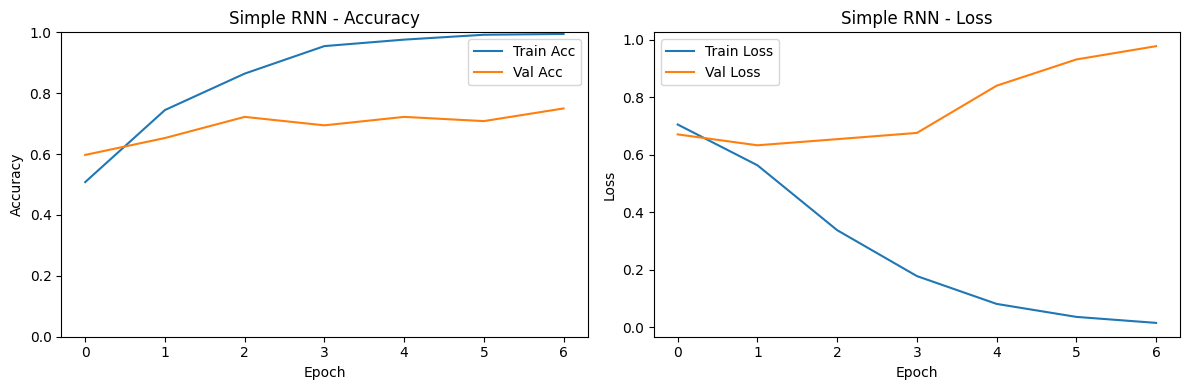

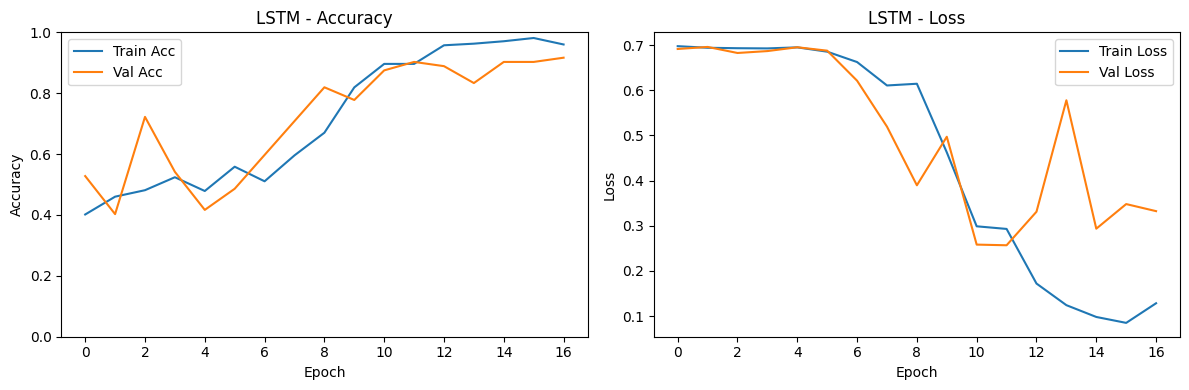

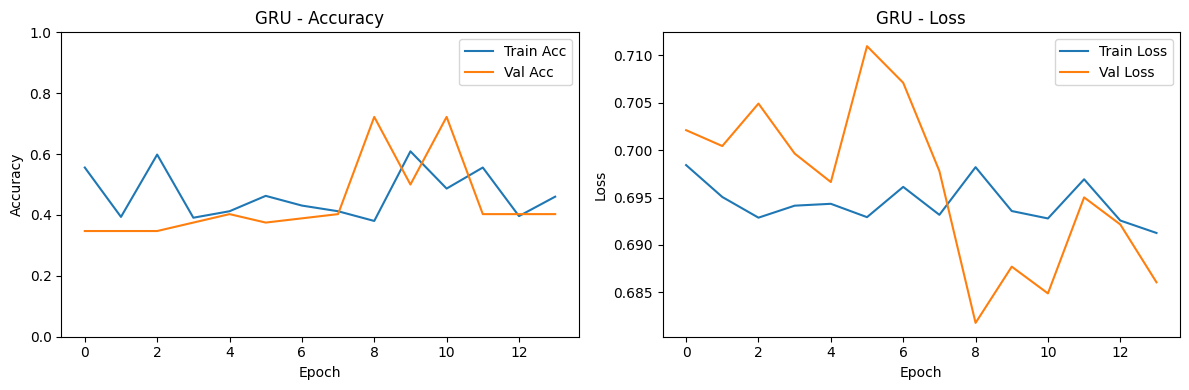

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix y-axis from 0 to 1
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example calls
plot_history(history_rnn, 'Simple RNN')
plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


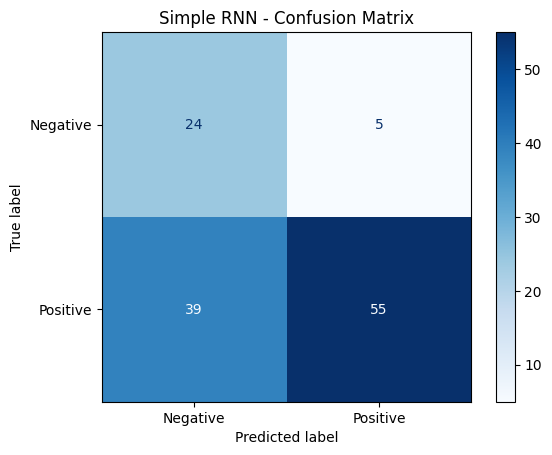

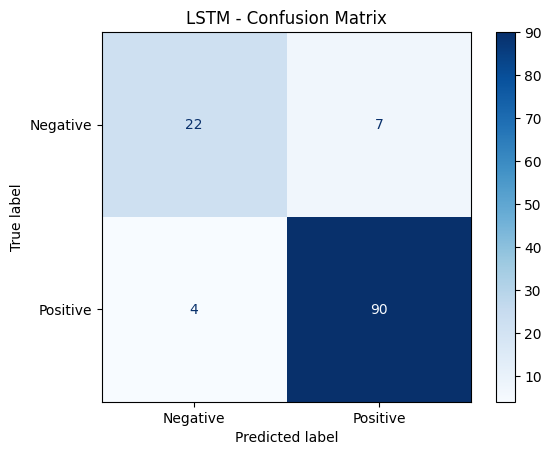

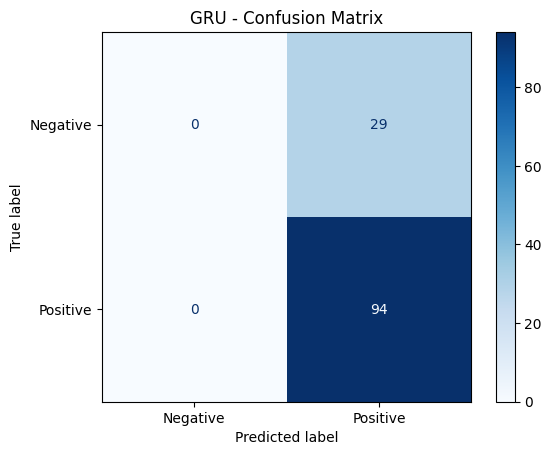

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Class label mapping
label_map = {0: "Negative", 1: "Positive"}

# Convert one-hot predictions to class indices
y_pred_rnn = np.argmax(simple_rnn_model.predict(X_test), axis=1)
y_pred_lstm = np.argmax(lstm_model.predict(X_test), axis=1)
y_pred_gru = np.argmax(gru_model.predict(X_test), axis=1)

# True labels
y_true = np.argmax(y_test_cat, axis=1)

models = {
    "Simple RNN": y_pred_rnn,
    "LSTM": y_pred_lstm,
    "GRU": y_pred_gru
}

for name, preds in models.items():
    # Combine true and predicted labels to get full label range
    all_labels = np.unique(np.concatenate([y_true, preds]))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, preds, labels=all_labels)

    # Get display labels from mapping
    display_labels = [label_map[i] for i in all_labels]

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()




## Model improvement

In [ ]:
!pip install keras-tuner


#### LSTN

In [ ]:
import shutil

# Replace with your actual tuner directory path
shutil.rmtree('lstm_tuning/sentiment_analysis', ignore_errors=True)
print("Old tuner directory deleted — ready for fresh tuning!")



Old tuner directory deleted — ready for fresh tuning!


Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.9027777910232544

Best val_accuracy So Far: 0.9305555820465088
Total elapsed time: 00h 01m 00s
Best hyperparameters:
Embedding dimension: 100
LSTM units: 96
LSTM dropout: 0.4
Dropout rate: 0.2
Learning rate: 0.0008643979656783194
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9887 - loss: 0.0497 - val_accuracy: 0.9167 - val_loss: 0.3604
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9781 - loss: 0.0911 - val_accuracy: 0.9028 - val_loss: 0.2824
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9968 - loss: 0.0220 - val_accuracy: 0.9306 - val_loss: 0.3198
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9919 - loss: 0.0277 - val_accuracy: 0.9028 - val_loss: 0.4349
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9884 - loss: 0.0568 - val_accuracy: 0.9167 - val_loss: 0.3436
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9881 - loss: 0.0365 - val_accuracy: 0.9028 - val_loss: 0.4294
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9969 - loss: 0.0174 - val_accuracy: 0.9028 - val_loss: 0.4766


Model saved successfully!
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9037 - loss: 0.3922
Test Loss: 0.3690, Test Accuracy: 0.9024
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.76      0.79        29
    Positive       0.93      0.95      0.94        94

    accuracy                           0.90       123
   macro avg       0.87      0.85      0.86       123
weighted avg       0.90      0.90      0.90       123



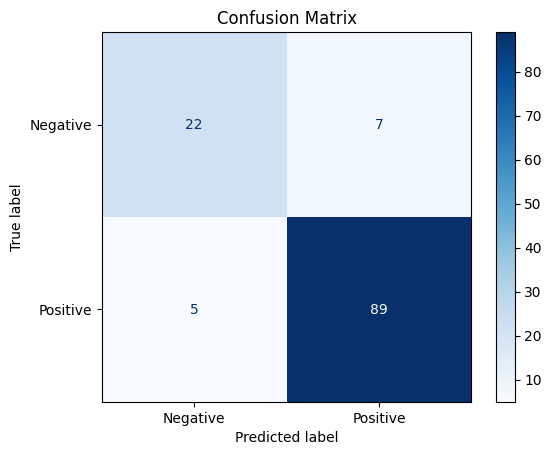

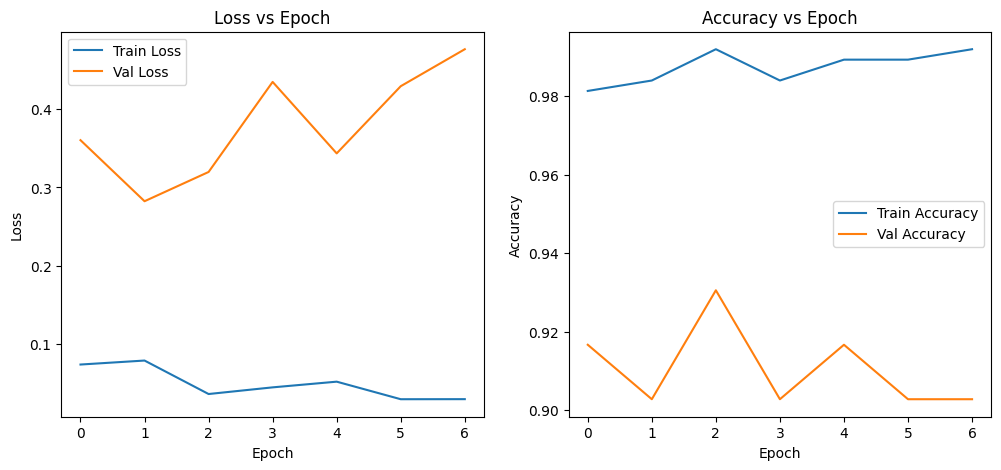

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 100)        │        64,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 96)             │        75,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,128 (1.60 MB)

 Trainable params: 140,042 (547.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 280,086 (1.07 MB)

In [ ]:
def build_model(hp):
    model = Sequential()
    # Tune embedding dimension
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100, 150])
    model.add(Embedding(input_dim=input_dimention, output_dim=embedding_dim, input_length=maxlen))

    # Tune number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=lstm_units, dropout=hp.Float('lstm_dropout', 0.1, 0.5, step=0.1)))

    # Tune dropout after LSTM
    dropout_rate = hp.Float('dropout', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))

    # Tune learning rate for Adam optimizer
    learning_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create tuner object
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='sentiment_analysis'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run hyperparameter search
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Your existing tuner setup and search ---

# Run hyperparameter search
tuner.search(
    X_train, y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(f"Embedding dimension: {best_hp.get('embedding_dim')}")
print(f"LSTM units: {best_hp.get('lstm_units')}")
print(f"LSTM dropout: {best_hp.get('lstm_dropout')}")
print(f"Dropout rate: {best_hp.get('dropout')}")
print(f"Learning rate: {best_hp.get('lr')}")

# Retrain best model to get training history
history = best_model.fit(
    X_train, y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Save best model to your drive
best_model.save('/content/drive/MyDrive/Colab Notebooks/deleca1/LSTM_best_model.h5')
print("Model saved successfully!")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predictions for metrics
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Define class labels
class_labels = ["Negative", "Positive"]

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

# Print best model architecture summary
best_model.summary()



In [ ]:
import shutil

shutil.rmtree('gru_tuning/sentiment_analysis_gru', ignore_errors=True)
# or if your tuner directory is 'lstm_tuning/sentiment_analysis', delete that instead
# shutil.rmtree('lstm_tuning/sentiment_analysis', ignore_errors=True)


#### GRU

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.5416666865348816

Best val_accuracy So Far: 0.9444444179534912
Total elapsed time: 00h 00m 58s
Best hyperparameters:
Embedding dimension: 100
GRU units: 32
GRU dropout: 0.30000000000000004
Dropout rate: 0.5
Learning rate: 0.002379397564129017
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9776 - loss: 0.0706 - val_accuracy: 0.9028 - val_loss: 0.3490
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9809 - loss: 0.0478 - val_accuracy: 0.9444 - val_loss: 0.2636
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9897 - loss: 0.0358 - val_accuracy: 0.9306 - val_loss: 0.2613
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9895 - loss: 0.0362 - val_accuracy: 0.9167 - val_loss: 0.2552
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9921 - loss: 0.0173 - val_accuracy: 0.9306 - val_loss: 0.2498
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9927 - loss: 0.0256 - val_accuracy: 0.9306 - val_loss: 0.3977
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9968 - loss: 0.0084 - val_accuracy: 0.9444 - val_loss: 0.3220
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9971 - loss: 0.0079 - val_accuracy: 0.9306 - val_loss: 0.

Test loss, Test accuracy: [0.37617233395576477, 0.9268292784690857]
Best GRU model saved to /content/drive/MyDrive/Colab Notebooks/deleca1/GRU_best_model.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


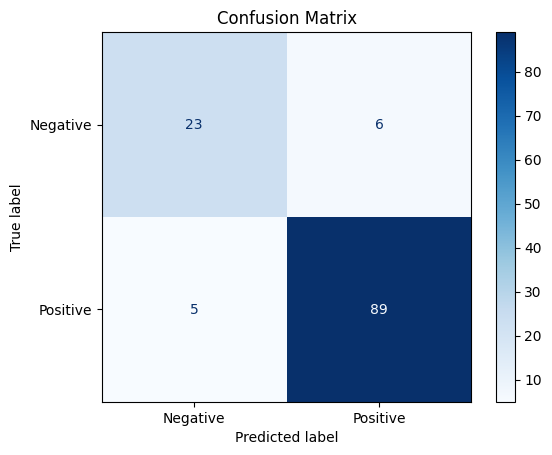

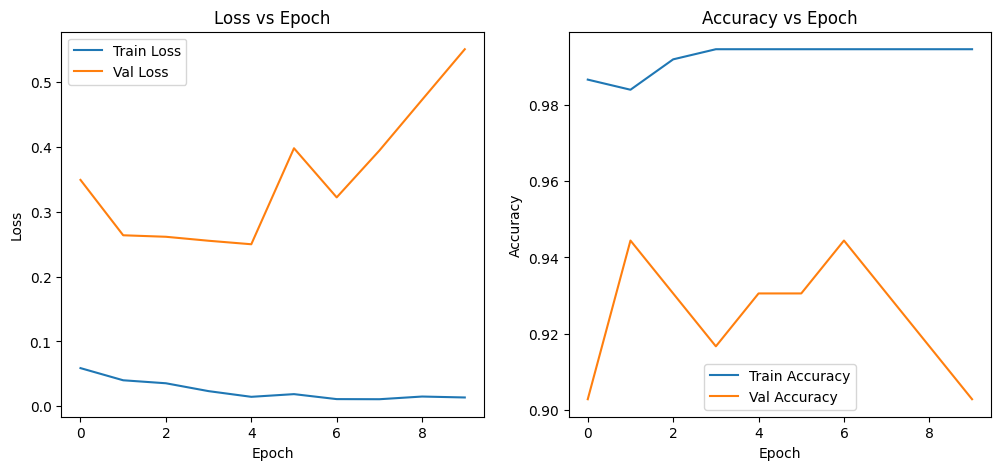

Classification Report:

              precision    recall  f1-score   support

    Negative       0.82      0.79      0.81        29
    Positive       0.94      0.95      0.94        94

    accuracy                           0.91       123
   macro avg       0.88      0.87      0.87       123
weighted avg       0.91      0.91      0.91       123



In [ ]:


def build_model(hp):
    model = Sequential()
    # Tune embedding dimension
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100, 150])
    model.add(Embedding(input_dim=input_dimension, output_dim=embedding_dim, input_length=maxlen))

    # Tune number of GRU units
    gru_units = hp.Int('gru_units', min_value=32, max_value=128, step=32)
    model.add(GRU(units=gru_units, dropout=hp.Float('gru_dropout', 0.1, 0.5, step=0.1)))

    # Tune dropout after GRU
    dropout_rate = hp.Float('dropout', 0.1, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))

    # Tune learning rate for Adam optimizer
    learning_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create tuner object
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='gru_tuning',
    project_name='sentiment_analysis_gru'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run hyperparameter search
tuner.search(
    X_train, y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(f"Embedding dimension: {best_hp.get('embedding_dim')}")
print(f"GRU units: {best_hp.get('gru_units')}")
print(f"GRU dropout: {best_hp.get('gru_dropout')}")
print(f"Dropout rate: {best_hp.get('dropout')}")
print(f"Learning rate: {best_hp.get('lr')}")

# Retrain best_model to get history for plotting
history = best_model.fit(
    X_train, y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Evaluate on test data
results = best_model.evaluate(X_test, y_test_cat)
print("Test loss, Test accuracy:", results)

# Save the best model
save_path = '/content/drive/MyDrive/Colab Notebooks/deleca1/GRU_best_model.h5'
best_model.save(save_path)
print(f"Best GRU model saved to {save_path}")

# Predict on test data
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Plot confusion matrix
class_labels = ["Negative", "Positive"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

# Print classification report with precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

